# NLP Milestone 1
A notebook to preprocess youtube transcripts of Al Mokhbir Al Eqtsadi episodes.

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import pyarabic.araby as araby
from nltk.corpus import stopwords
import nltk
from typing import List
from tqdm.notebook import tqdm
import arabic_reshaper 
from bidi.algorithm import get_display
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from collections import Counter

### 1. Data Loading

In [ ]:
def read_episodes_files(file_path: str) -> pd.DataFrame:
    """
    Read all the episodes files in the file_path and return a DataFrame with the content of the files.
    """
    episodes_files = []
    for file in os.listdir(file_path):
        if file.endswith(".txt"):
            with open(file_path + file, 'r') as f:
                episodes_files.append(f.read())
    df = pd.DataFrame(episodes_files, columns=['episode_transcript'])
    return df

In [3]:
df = read_episodes_files('Al_Mokhbir_Al_Eqtisadi/raw_data/')
df.head()

episode_transcript
0  بعد سبعه اشهر وانا لا اجرؤ على حذف شيء\nيخصك م...
1  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...
2  على غير العادة وبدون أي مقدمات\nخلونا نبدأ الح...
3  من حوالي السنتين\nوتحديداً في 3 ديسمبر 2020\nج...
4  يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...

### 2. Data Understanding

In [ ]:
# View number of samples
df.shape

(222, 1)

In [ ]:
# View average transcript length 
df['episode_transcript'].apply(len).mean()

14161.801801801801

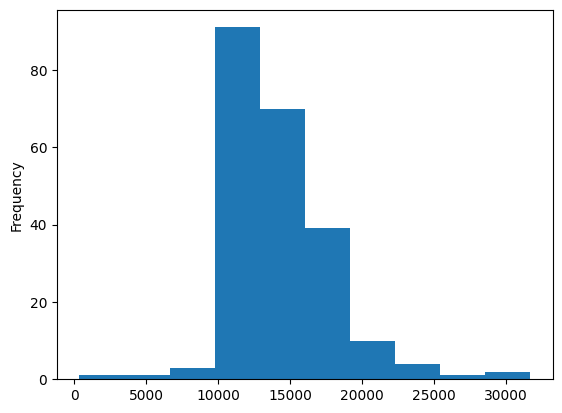

In [6]:
# View the histogram of transcript lengths
df['episode_transcript'].apply(len).plot(kind='hist')
plt.show()

In [7]:
# View average transcript word count
int(df['episode_transcript'].apply(lambda x: len(x.split())).mean())

2511

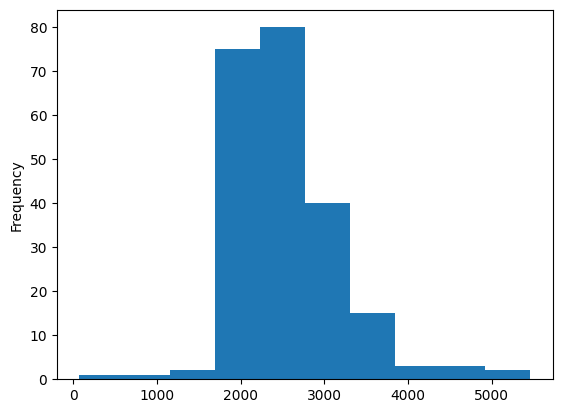

In [8]:
# View the histogram of transcript word count
df['episode_transcript'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.show()

In [9]:
# View a couple of samples
print(df.values[0][0])

بعد سبعه اشهر وانا لا اجرؤ على حذف شيء
يخصك ما اليوم ازيل تطبيقات الالعاب التي
حملتم على جهازي اخرج من المجموعات
التعليميه الخاصه بكما الغي متابعتي لكل
صفحه اراها امامي تعرض ملابس الاطفال
والعابهم لم يكن قتلكم كابوسا كما ظننت بل
كان افضع حقيقه هي قصه ام من امهات غزه
خسرت اطفالها هي قصه من 15000 قصه لاكثر
من 15000 طفل قتلهم الاحت خلوا عينكم على
غزه خلوا عينكم على رفاح



In [10]:
# Check if there are any missing values
df.isna().sum()

episode_transcript    0
dtype: int64

In [11]:
# Check if there are any duplicates
df.duplicated().sum()

0

In [12]:
# Check if there are very short or very long transcripts
df['transcript_length'] = df['episode_transcript'].apply(len)
df['transcript_length'].describe()

count      222.000000
mean     14161.801802
std       3645.946027
min        370.000000
25%      11721.250000
50%      13418.500000
75%      16070.500000
max      31704.000000
Name: transcript_length, dtype: float64

<Axes: ylabel='Frequency'>

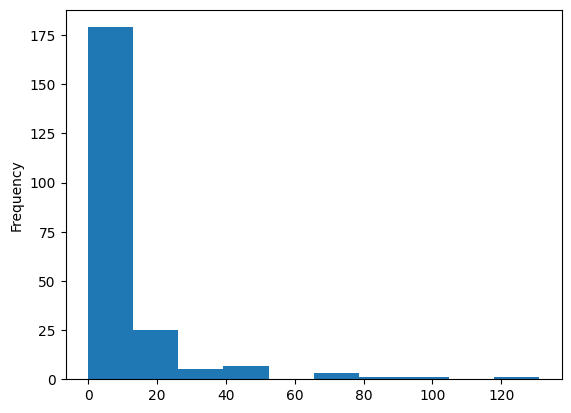

In [13]:
def count_non_arabic_words(text: str) -> int:
    """
    Count the number of non-arabic words in a text, that are also not a number
    """
    non_arabic_words = 0
    for word in text.split():
        if re.search(r'[a-zA-Z]', word):
            non_arabic_words += 1
    return non_arabic_words

# Apply the function on the DataFrame
df['non_arabic_words_count'] = df['episode_transcript'].apply(count_non_arabic_words)

# Plot the distribution of non-arabic words
df['non_arabic_words_count'].plot(kind='hist')

It can seen from the histogram that `Al Mokhbir Al Eqtisadi` uses small number of english phrases in his episodes

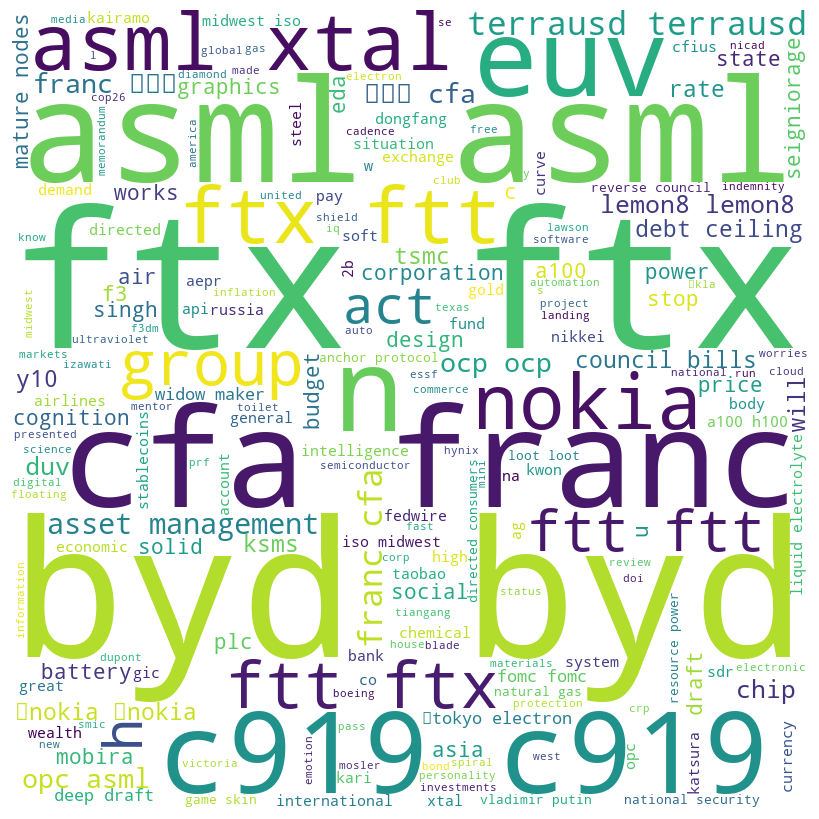

In [ ]:
from wordcloud import WordCloud

# Create a word cloud for the most common non-arabic words
non_arabic_words = ' '.join(df['episode_transcript'].apply(lambda x: ' '.join([word.lower() for word in x.split() if re.search(r'[a-zA-Z]', word)])))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(non_arabic_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

It can be seen from the above word cloud that most of the english phrases used are
1. Company Names
2. Country Names
3. Buisness Expressions 
and others

In [37]:

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

def extract_non_arabic_words(text, remove_stopwords=False):
    """
    Extracts non-Arabic words from text, removes punctuation, and optionally filters stopwords.

    Parameters:
    - text (str): The input text.
    - remove_stopwords (bool): Whether to remove English stopwords (default: False).

    Returns:
    - List of cleaned non-Arabic words.
    """
    words = text.split()
    
    # Keep words with Latin characters and remove punctuation
    non_arabic = [re.sub(r'[^a-zA-Z]', '', word).lower() for word in words if re.search(r'[a-zA-Z]', word)]
    
    # Remove empty strings
    non_arabic = list(filter(None, non_arabic))
    
    # Optionally remove stopwords
    if remove_stopwords:
        non_arabic = [word for word in non_arabic if word not in english_stopwords]

    return non_arabic

def generate_non_arabic_wordcloud(df, column_name, remove_stopwords=False):
    """
    Generates a word cloud for non-Arabic words in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing text data.
    - column_name (str): The name of the column containing text.
    - remove_stopwords (bool): Whether to remove English stopwords (default: False).
    """
    # Extract non-Arabic words from the specified column
    non_arabic_words = df[column_name].dropna().apply(lambda x: extract_non_arabic_words(x, remove_stopwords)).tolist()
    
    # Flatten the list
    flattened_words = [word for sublist in non_arabic_words for word in sublist]
    
    # Count word frequencies
    word_freq = Counter(flattened_words)
    
    # Generate the word cloud from frequencies
    wordcloud = WordCloud(width=800, 
                          height=800, 
                          background_color='white', 
                          min_font_size=10).generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


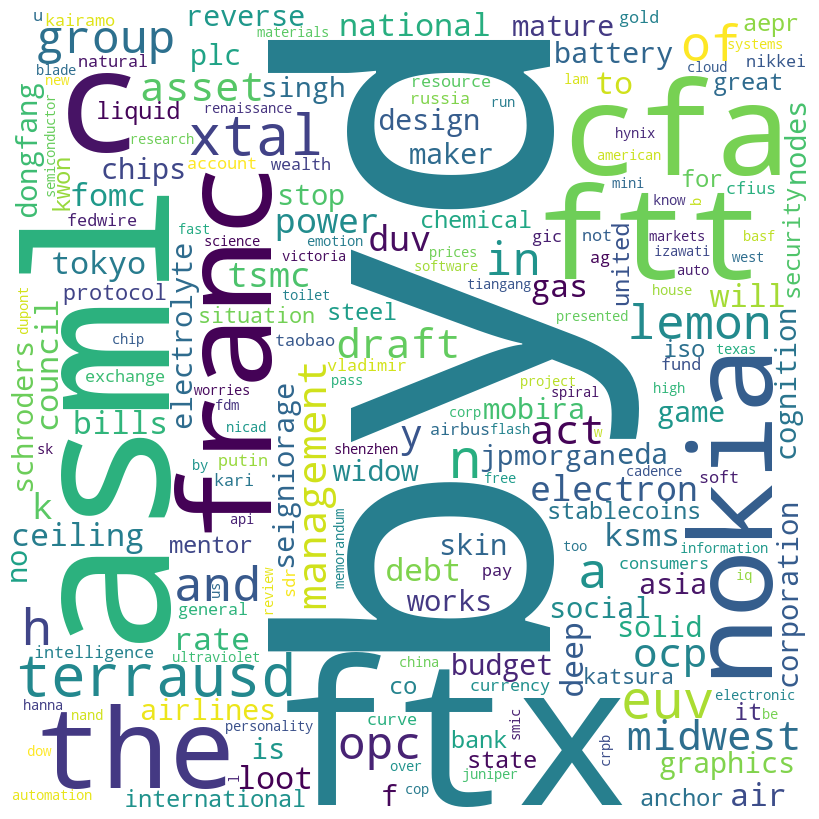

In [38]:
generate_non_arabic_wordcloud(df, column_name='episode_transcript', remove_stopwords=False)

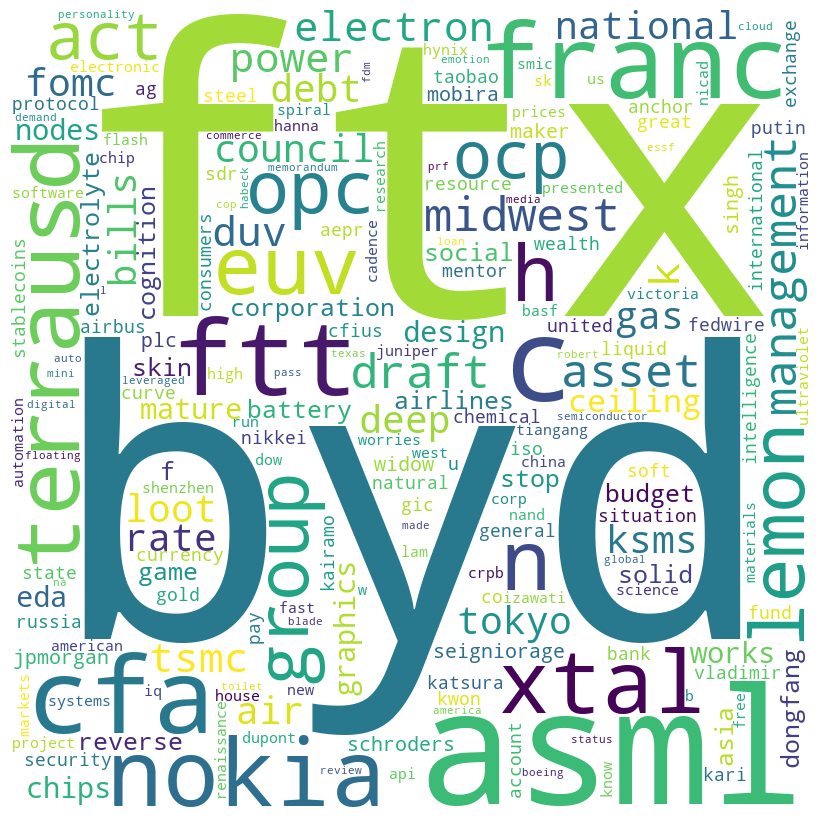

In [39]:
generate_non_arabic_wordcloud(df, column_name='episode_transcript', remove_stopwords=True)

### 3. Data Preprocessing & Cleaning

In [15]:
# Cleaning function
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

def clean_arabic_txt(text: str) -> str:
    """
    Clean the Arabic text by removing any non-Arabic characters, special tags, timestamps, and stopwords.
    """
    text = re.sub(r'\[\d{2}:\d{2}:\d{2}\]', '', text)  # Remove timestamps
    text = re.sub(r'\[.*?\]', '', text) # Remove special tags like [موسيقى], [ضحك], etc.
    text = re.sub(r'\d+', '', text)     # Remove dates  and numbers
    text = araby.strip_tashkeel(text) 
    text = araby.strip_tatweel(text) 
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])
    return text

# Apply the cleaning function
df['cleaned_transcript'] = df['episode_transcript'].apply(clean_arabic_txt)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


episode_transcript  transcript_length  \
0  بعد سبعه اشهر وانا لا اجرؤ على حذف شيء\nيخصك م...                370   
1  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...              18330   
2  على غير العادة وبدون أي مقدمات\nخلونا نبدأ الح...              16159   
3  من حوالي السنتين\nوتحديداً في 3 ديسمبر 2020\nج...              12659   
4  يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...              11463   

   non_arabic_words_count                                 cleaned_transcript  
0                       0  سبعه اشهر وانا اجرؤ حذف شيء يخصك اليوم ازيل تط...  
1                       0  عمان وقطر والبحرين والسعوديه دي الدول العربيه ...  
2                       2  العادة وبدون مقدمات خلونا نبدأ الحلقة وندخل ال...  
3                      41  حوالي السنتين وتحديدا جون راتكليف مدير الاستخب...  
4                      22  يوم تم إعلان وفاة ملكة بريطانيا إليزبيث الثاني...

In [16]:
print(df.values[0][2])

0


#### Tokenization

In [17]:
from farasa.segmenter import FarasaSegmenter

def tokenize(episodes: List[str]) -> List[List[str]]:
    """
    Tokenize a list of Arabic text strings using Farasa and clean the tokens.

    Args:
    - episodes (list of str): List of strings to be tokenized.

    Returns:
    - List of Lists: Cleaned and tokenized text for each episode.
    """
    farasa_segmenter = FarasaSegmenter(interactive=True)

    tokenized_episodes = []    
    for episode in tqdm(episodes):
        segmented_episode = farasa_segmenter.segment(episode)
        episode_split = segmented_episode.split()
        episode_tokenized = []
        for word in episode_split:
            if '+' in word:
                word_split = word.split('+')
                episode_tokenized.extend(word_split)
            else:
                episode_tokenized.append(word)
        tokenized_episodes.append(episode_tokenized)

    return tokenized_episodes


In [18]:
episodes = df['cleaned_transcript'].values.tolist()
cleaned_tokenized = tokenize(episodes=episodes)
df['tokenized_transcript'] = cleaned_tokenized
print(cleaned_tokenized)

[2025-03-01 03:21:58,045 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


  0%|          | 0/222 [00:00<?, ?it/s]

[['سبع', 'ه', 'أشهر', 'و', 'أنا', 'اجرؤ', 'حذف', 'شيء', 'يخصك', 'ال', 'يوم', 'ازيل', 'تطبيق', 'ات', 'ال', 'ألعاب', 'حملتم', 'جهاز', 'ي', 'أخرج', 'ال', 'مجموع', 'ات', 'ال', 'تعليميه', 'الخاص', 'ه', 'ال', 'غي', 'متابع', 'ت', 'ي', 'ل', 'كل', 'صفح', 'ه', 'ارا', 'ها', 'امامي', 'تعرض', 'ملابس', 'ال', 'أطفال', 'و', 'العاب', 'هم', 'يكن', 'قتل', 'كم', 'كابوس', 'ا', 'ظنن', 'ت', 'افضع', 'حقيق', 'ه', 'قص', 'ه', 'ام', 'أمه', 'ات', 'غز', 'ه', 'خسر', 'ت', 'اطفال', 'ها', 'قص', 'ه', 'قص', 'ه', 'ل', 'أكثر', 'طفل', 'قتل', 'هم', 'الاح', 'ت', 'خلو', 'ا', 'عين', 'كم', 'غز', 'ه', 'خلو', 'ا', 'عين', 'كم', 'رفاح'], ['عمان', 'و', 'قطر', 'و', 'ال', 'بحرين', 'و', 'السعودي', 'ه', 'دي', 'ال', 'دول', 'ال', 'عربيه', 'ال', 'اربعه', 'اللي', 'زار', 'ها', 'ملك', 'بريطانيا', 'ال', 'حالي', 'و', 'أمير', 'ويلز', 'ال', 'سابق', 'تشارلز', 'ال', 'ثالث', 'زوج', 'ت', 'ه', 'أمير', 'ه', 'ويلز', 'الراحل', 'ه', 'ال', 'اميره', 'ديانا', 'سن', 'ه', 'تشارلز', 'و', 'ديان', 'ا', 'لف', 'وا', 'ال', 'دول', 'ال', 'عربيه', 'ال', 'اربعه', 'رحل', 

In [19]:
df.head()

episode_transcript  transcript_length  \
0  بعد سبعه اشهر وانا لا اجرؤ على حذف شيء\nيخصك م...                370   
1  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...              18330   
2  على غير العادة وبدون أي مقدمات\nخلونا نبدأ الح...              16159   
3  من حوالي السنتين\nوتحديداً في 3 ديسمبر 2020\nج...              12659   
4  يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...              11463   

   non_arabic_words_count                                 cleaned_transcript  \
0                       0  سبعه اشهر وانا اجرؤ حذف شيء يخصك اليوم ازيل تط...   
1                       0  عمان وقطر والبحرين والسعوديه دي الدول العربيه ...   
2                       2  العادة وبدون مقدمات خلونا نبدأ الحلقة وندخل ال...   
3                      41  حوالي السنتين وتحديدا جون راتكليف مدير الاستخب...   
4                      22  يوم تم إعلان وفاة ملكة بريطانيا إليزبيث الثاني...   

                                tokenized_transcript  
0  [سبع, ه, أشهر, و, أنا, اجرؤ, حذف, شيء, يخصك, ا...  
1  [عمان, و, قطر, و, ال, بحرين, و, السعودي, ه, دي...  
2  [ال, عاد, ة, و, ب, دون, مقدم, ات, خلو, نا, نبد...  
3  [حوالي, ال, سن, ت, ين, و, تحديد, ا, جون, راتكل...  
4  [يوم, تم, إعلان, وفا, ة, ملك, ة, بريطانيا, إلي...

#### Stemming

In [20]:
from farasa.stemmer import FarasaStemmer

def stem(episodes: List[List[str]]) -> List[List[str]]:
    """
    Stem a list of Arabic tokens using Farasa.

    Args:
    - episodes (list of list of str): List of tokenized strings to be stemmed.

    Returns:
    - List of Lists: Stemmed text for each episode.
    """
    farasa_stemmer = FarasaStemmer(interactive=True)

    stemmed_episodes = []
    for episode in tqdm(episodes):
        stemmed_episode = []
        for word in episode:
            stemmed_word = farasa_stemmer.stem(word)
            stemmed_episode.append(stemmed_word)
        stemmed_episodes.append(stemmed_episode)

    return stemmed_episodes

In [21]:
episodes = df['tokenized_transcript'].values.tolist()
stemmed_tokenized = stem(episodes)
df['stemmed_transcript'] = stemmed_tokenized
df.head()

[2025-03-01 03:22:15,616 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


  0%|          | 0/222 [00:00<?, ?it/s]

episode_transcript  transcript_length  \
0  بعد سبعه اشهر وانا لا اجرؤ على حذف شيء\nيخصك م...                370   
1  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...              18330   
2  على غير العادة وبدون أي مقدمات\nخلونا نبدأ الح...              16159   
3  من حوالي السنتين\nوتحديداً في 3 ديسمبر 2020\nج...              12659   
4  يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...              11463   

   non_arabic_words_count                                 cleaned_transcript  \
0                       0  سبعه اشهر وانا اجرؤ حذف شيء يخصك اليوم ازيل تط...   
1                       0  عمان وقطر والبحرين والسعوديه دي الدول العربيه ...   
2                       2  العادة وبدون مقدمات خلونا نبدأ الحلقة وندخل ال...   
3                      41  حوالي السنتين وتحديدا جون راتكليف مدير الاستخب...   
4                      22  يوم تم إعلان وفاة ملكة بريطانيا إليزبيث الثاني...   

                                tokenized_transcript  \
0  [سبع, ه, أشهر, و, أنا, اجرؤ, حذف, شيء, يخصك, ا...   
1  [عمان, و, قطر, و, ال, بحرين, و, السعودي, ه, دي...   
2  [ال, عاد, ة, و, ب, دون, مقدم, ات, خلو, نا, نبد...   
3  [حوالي, ال, سن, ت, ين, و, تحديد, ا, جون, راتكل...   
4  [يوم, تم, إعلان, وفا, ة, ملك, ة, بريطانيا, إلي...   

                                  stemmed_transcript  
0  [سبع, ه, شهر, و, أنا, اجرؤ, حذف, شيء, يخصك, ال...  
1  [عمان, و, قطر, و, ال, بحر, و, سعودي, ه, دي, ال...  
2  [ال, عاد, , و, ب, دون, مقدم, ات, خلو, نا, بدأ,...  
3  [حوالي, ال, سن, ت, ين, و, تحديد, ا, جون, راتكل...  
4  [يوم, تم, إعلان, وفا, , ملك, , بريطانيا, إليزب...

##### Analysis

In [ ]:
def column_to_wordcloud(df, column, font_file): 
    """
    Parameters:
      df: the dataframe that contains the column 
      column: the name of the column that contains the text 
      font_file: the path to the font file for Arabic characters 
      stopwords: a list of words to exclude from the wordcloud

    Outputs:
        None. The function only displays the word cloud image.
    """
    text = " ".join(t for t in df[column].dropna())
    reshaped_text = arabic_reshaper.reshape(text)
    display_text = get_display(reshaped_text)  

    wordcloud = WordCloud(font_path=font_file, width=800, height=400, random_state=1,
                          background_color='white', collocations=False).generate(display_text)

    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

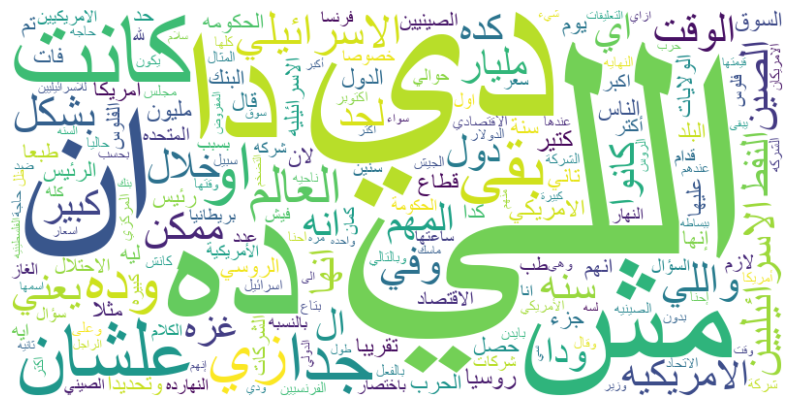

In [23]:
font_file = './arial.ttf'
column_to_wordcloud(df, 'cleaned_transcript', font_file= font_file)

Analysis
- Do phrase cloud on raw data
- Word cloud after removing stopwords
- tf idf on raw data (not sure)
- bigram on raw data
- clustering/categorization
- sarcasm detection
- hal duration of episode correlated ma3 length of episode transcript (tokens)
- Hugging face pretraiend models lel analysis keteer b2a

#### Phrase Cloud

In [30]:
def generate_phrase_cloud(
        df: pd.DataFrame, 
        column_name: str, 
        ngram: int=2, 
        background_color: str='white', 
        max_words: int=200, 
        font_path: str='./arial.ttf'):
    """
    Generates a phrase cloud from a specified column in a DataFrame, supporting Arabic text.
    Only n-gram phrases are displayed, avoiding single words.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the text data.
    - column_name (str): The name of the column containing the text.
    - ngram (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
    - background_color (str): Background color for the word cloud.
    - max_words (int): Maximum number of words to display in the cloud.
    - font_path (str): Path to an Arabic font (.ttf) file.
    
    Returns:
    - Displays the generated phrase cloud.
    """

    def clean_and_tokenize(text):
        text = text.lower()  
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        tokens = text.split()  
        return tokens

    df['tokens'] = df[column_name].dropna().astype(str).apply(clean_and_tokenize)
    tokens_list = df['tokens'].tolist()
    
    def generate_ngrams(tokens, n):
        ngrams = zip(*[tokens[i:] for i in range(n)])
        return ['_'.join(ngram) for ngram in ngrams]
    
    all_ngrams = []
    for tokens in tokens_list:
        ngrams = generate_ngrams(tokens, ngram)
        all_ngrams.extend(ngrams)
    
    phrase_text = " ".join(all_ngrams)
    
    reshaped_text = arabic_reshaper.reshape(phrase_text)
    display_text = get_display(reshaped_text)  
    
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color=background_color, 
                          max_words=max_words, 
                          font_path=font_path  
                          ).generate(display_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


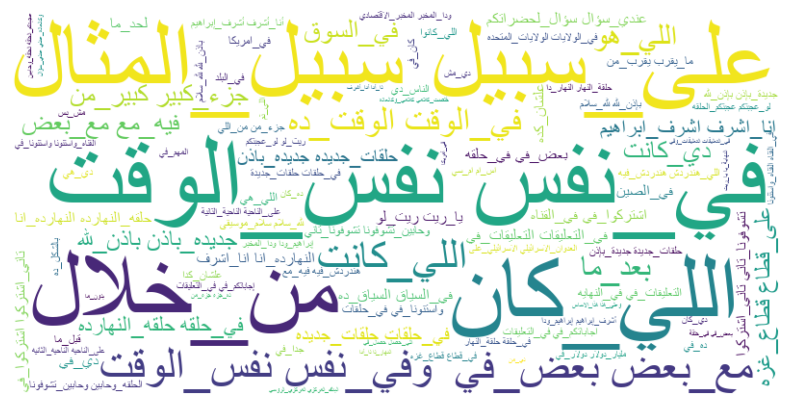

In [33]:
generate_phrase_cloud(df, 'episode_transcript', ngram=2, background_color='white', max_words=100)

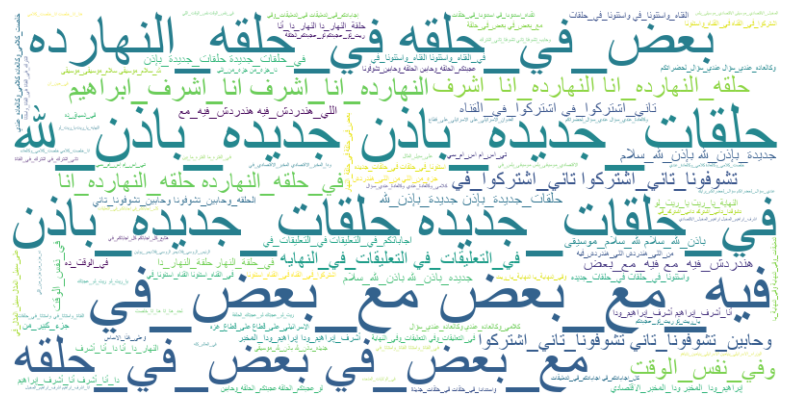

In [34]:
generate_phrase_cloud(df, 'episode_transcript', ngram=3, background_color='white', max_words=100)

In [ ]:
def generate_top_k_ngrams(
        df: pd.DataFrame, 
        column_name: str, 
        ngram: int=2, 
        k: int=10):
    """
    Generates the most repeated n-grams from a specified column in a DataFrame
    and displays the top k phrases as a bar chart. Supports Arabic text.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the text data.
    - column_name (str): The name of the column containing the text.
    - ngram (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
    - k (int): The number of top phrases to display.
    
    Returns:
    - Displays a bar chart of the most repeated k phrases.
    """

    def clean_and_tokenize(text):
        text = text.lower()  
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        tokens = text.split()  
        return tokens

    df['tokens'] = df[column_name].dropna().astype(str).apply(clean_and_tokenize)
    tokens_list = df['tokens'].tolist()
    
    def generate_ngrams(tokens, n):
        ngrams = zip(*[tokens[i:] for i in range(n)])
        return [' '.join(ngram) for ngram in ngrams]
    
    all_ngrams = []
    for tokens in tokens_list:
        ngrams = generate_ngrams(tokens, ngram)
        all_ngrams.extend(ngrams)
    
    ngram_counter = Counter(all_ngrams)
    most_common_ngrams = ngram_counter.most_common(k)
    
    phrases, counts = zip(*most_common_ngrams)
    
    reshaped_phrases = [get_display(arabic_reshaper.reshape(phrase)) for phrase in phrases]
    
    plt.figure(figsize=(12, 6))
    plt.barh(reshaped_phrases, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top {k} Most Repeated {ngram}-grams')
    plt.gca().invert_yaxis()  
    plt.show()


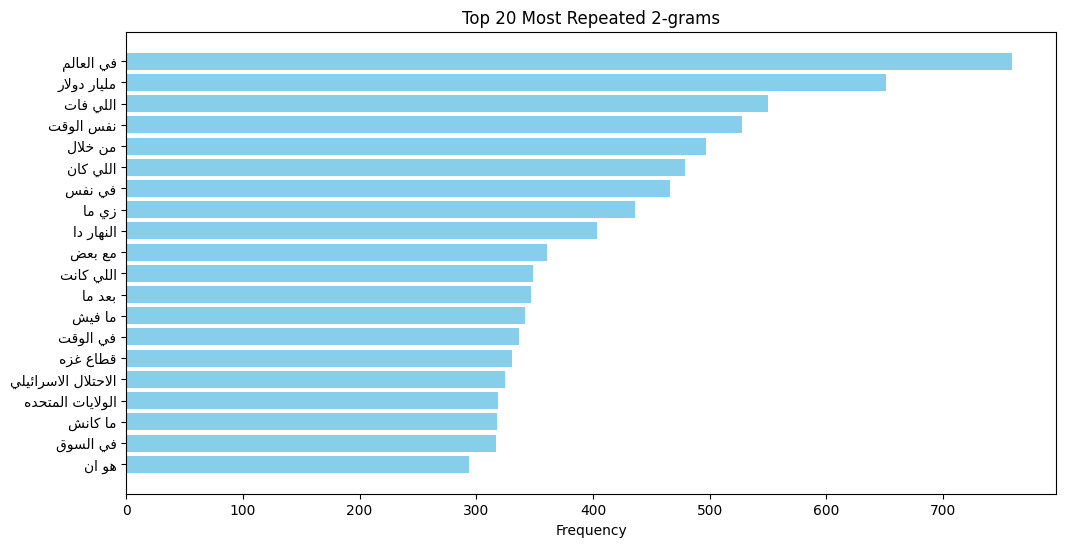

In [28]:
generate_top_k_ngrams(df, column_name='episode_transcript', ngram=2, k=20)

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


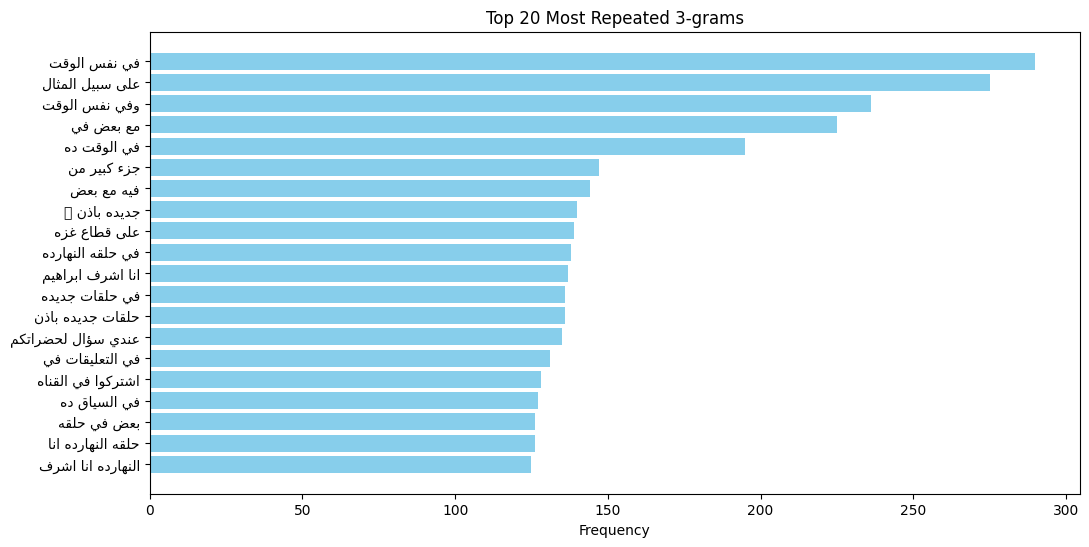

In [29]:
generate_top_k_ngrams(df, column_name='episode_transcript', ngram=3, k=20)